In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr
import spacy
nlp = spacy.load("en_core_web_sm")


from nltk.corpus import wordnet as wn
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer, LancasterStemmer
import itertools
import re


In [3]:
# For sake of simplicity, the metrics are defined as functions
def dice_sim(x, y):
    x_n_y = x.intersection(y)
    try:
        return 2*len(x_n_y) / (len(x) + len(y))
    except ZeroDivisionError:
        print(x, y)
        return 1

def get_synsets(word):
    '''
    Generate derivationally related lemmas from a given word
    '''
    # In order to make more likely the match between a verb
    # and a related adjective (for example), related forms
    # are generated for every word interpretation (a, v, n, r)
    ls_synsets = wn.synsets(word)

    # get lemmas from synsets
    ls_lemmas = [l.lemmas() for l in ls_synsets]
    ls_lemmas = sum(ls_lemmas, [])
    # Extract derivationally related forms
    derivationally_related_forms = sum([l.derivationally_related_forms() for l in ls_lemmas], [])
    output = [l.name() for l in derivationally_related_forms + ls_lemmas]
    
    return set(output)


def sentence_sim_terms(s1, s2):
    '''
    Given 2 sentences:
        - check if 2 words in them have any synset in common
        - I fthat's the case, replace the word in the 2nd sentence for the related one
    '''
    doc1 = nlp(s1)
    doc2 = nlp(s2)

    ls_s1 = [w.text.lower() for w in doc1 if not w.is_stop and not w.is_punct]
    ls_s2 = [w.text.lower() for w in doc2 if not w.is_stop and not w.is_punct]

    d_out = {}
    for x, y in itertools.product(ls_s1, ls_s2):       
        # check splits
        if (len(get_synsets(x).intersection(get_synsets(y))) > 0)&(x not in ls_s2):
            d_out[y] = x
 
    s1_out = " ".join(ls_s1)
    s2_out = " ".join([d_out[w] for w in ls_s2 if w in d_out] + [w for w in ls_s2 if w not in d_out])
  
    return s1_out, s2_out
   
class STSAnalyzer:

    def __init__(self, preprocess_fun, filename, similarity=dice_sim, semantic_fun=None):
        self.preprocess_fun = preprocess_fun
        self.filename = filename
        self.similarity = similarity
        self.semantic_fun = semantic_fun

    def get_similarity(self, x, y):
        '''
        Get the similarity between two strings
        '''
        if self.semantic_fun is not None:
            x_preprep, y_preprep = self.semantic_fun(x, y)
        else:
            x_preprep, y_preprep = x, y
            
        # Clean the sentences and return a set of words
        x_prep = self.preprocess_fun(x_preprep, out_set=True)
        y_prep = self.preprocess_fun(y_preprep, out_set=True)

        # Return the similarity between the two sets of words
        return self.similarity(x_prep, y_prep)
        
    def corr_with_gold(self, filename):
        '''
        Returns the correlation between the gold standard and the similarity
        Input: filename - string with the name of the file
        Output: Pearson correlation object
        '''

        # In some of the files, tabulations appear as \t instead of a tab
        # To solve this problem, it's been included \\t (escaped "\") as a possible separator
        dt = pd.read_csv('../test-gold/STS.input.' + filename, sep='\t|\\t',
                        header=None, on_bad_lines='skip', engine='python')
        dt['gs'] = pd.read_csv('../test-gold/STS.gs.'+ filename, sep='\t|\\t',header=None, 
                            on_bad_lines='skip', engine='python')
        
        # Bad lines are inserted as null values sometimes 
        # They are counted, informed and removed
        nulls = dt[dt.isnull().any(axis=1)]
        if len(nulls) > 0:
            print(filename, '\n', nulls)
            dt = dt.dropna()

        # Get the similarity between the two sentences
        arr_sim = dt.apply(lambda x: self.get_similarity(*x[:2]) , axis=1).values
        
        return pearsonr(arr_sim, dt['gs'].values)

    def ind_report(self, file=None):

        if file is None:
            file = self.filename

        print("=====================================================")
        print(file)
        print("=====================================================")
        print("\n")
        df_ind_report = pd.read_csv(f'../test-gold/STS.input.{file}',sep='\t|\\t',header=None, engine='python')
        df_ind_report['gs'] = pd.read_csv(f'../test-gold/STS.gs.{file}',sep='\t|\\t',header=None, engine='python')
        df_ind_report['sim'] = df_ind_report.apply(lambda x: self.get_similarity(*x[:2]) , axis=1)
        df_ind_report['sim'] *= 5.
        df_ind_report['dif'] = df_ind_report['sim'] - df_ind_report['gs']

        difs_tail = df_ind_report.sort_values(by='dif', ascending=False).tail(5)
        for idx, row in difs_tail.iterrows():
            x, y = row[0], row[1]
            prep_x, prep_y = self.preprocess_fun(x, out_set=True), self.preprocess_fun(y, out_set=True)
            print(f"RAW TEXT (DIFFERENCE {row['dif']:.2f})")
            print(x, '\n', y)
            print("\nPREPROCESSED TEXT")
            print(prep_x, '\n', prep_y)
            print("INTERSECTION", prep_x.intersection(prep_y))
            print("DIFFERENCE", prep_x.difference(prep_y).union(prep_y.difference(prep_x)))
            print('\n\n')

            if self.semantic_fun is not None:
                print("SEMANTICAL MODIFICATION\n")
                x, y = self.semantic_fun(row[0], row[1])
                prep_x, prep_y = self.preprocess_fun(x, out_set=True), self.preprocess_fun(y, out_set=True)
                print(f"RAW TEXT (DIFFERENCE {row['dif']:.2f})")
                print(x, '\n', y)
                print("\nPREPROCESSED TEXT")
                print(prep_x, '\n', prep_y)
                print("INTERSECTION", prep_x.intersection(prep_y))
                print("DIFFERENCE", prep_x.difference(prep_y).union(prep_y.difference(prep_x)))
                print('\n\n')

        fig, ax = plt.subplots(1, 2, figsize=(10,2.5))
        plt.suptitle(file)
        df_ind_report.dif.plot.hist(bins=20, title="Residuals", ax=ax[0])
        df_ind_report.dif.plot.box(title="Residuals", ax=ax[1]);
        
        self.df_ind_report = df_ind_report

    def corr_table(self, ls_files, name=None):
        
        df_scores = pd.DataFrame(columns=['file','pearson','p_value', 'conf_low', 'conf_high'])

        ls_corr = []
        ls_p_value = []
        ls_conf_low, ls_conf_high = [], []

        for file in ls_files:
            print(f"Processing {file}")
            pearson_stats = self.corr_with_gold(file)
            ls_corr.append(pearson_stats.statistic)
            ls_p_value.append(pearson_stats.pvalue)
            ls_conf_low.append(pearson_stats.confidence_interval(.95).low)
            ls_conf_high.append(pearson_stats.confidence_interval(.95).high)

        df_scores['file'] = ls_files
        df_scores['pearson'] = ls_corr
        df_scores['p_value'] = ls_p_value
        df_scores['conf_low'] = ls_conf_low
        df_scores['conf_high'] = ls_conf_high
        
        if name is not None:
            df_scores['name'] = name

        self.df_scores = df_scores
        return df_scores
    
    def col_report(self, ls_files):
        df_col_analysis = pd.DataFrame()
        for file in ls_files:
            self.ind_report(file)
            df_ind = self.df_ind_report
            df_ind['file'] = file
            df_col_analysis = pd.concat([df_col_analysis, df_ind], axis=0)
        
        self.df_col_analysis = df_col_analysis
        self.total_corr = pearsonr(df_col_analysis['sim'].values, df_col_analysis['gs'].values)

        

# Spacy Baseline

MSRpar.txt


RAW TEXT (DIFFERENCE -2.50)
The company claims it's the largest single Apple VAR Xserve sale to date. 
 The company claimed it is the largest sale of Xserves by an Apple retailer.

PREPROCESSED TEXT
{'xserve', 'apple', 'var', 'company', 'claims', 'sale', 'date', 'single', 'largest'} 
 {'retailer', 'largest', 'apple', 'company', 'xserves', 'sale', 'claimed'}
INTERSECTION {'company', 'sale', 'largest', 'apple'}
DIFFERENCE {'retailer', 'claims', 'xserves', 'date', 'xserve', 'var', 'single', 'claimed'}



RAW TEXT (DIFFERENCE -2.53)
But Odette is the first to form over the Caribbean Sea in December, the Center said. 
 It is the first named storm to develop in the Caribbean in December.

PREPROCESSED TEXT
{'caribbean', 'sea', 'form', 'odette', 'said', 'december', 'center'} 
 {'caribbean', 'december', 'develop', 'storm', 'named'}
INTERSECTION {'december', 'caribbean'}
DIFFERENCE {'sea', 'develop', 'storm', 'center', 'form', 'odette', 'named', 'said'}



RAW TEXT (DIFFERENCE -2.6

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.561517,1.552373e-63,0.510448,0.608640,baseline
1,MSRvid.txt,0.711438,1.043983e-116,0.674186,0.745079,baseline
2,SMTeuroparl.txt,0.500409,1.849060e-30,0.428508,0.566012,baseline
3,surprise.OnWN.txt,0.651994,5.473821e-92,0.608823,0.691316,baseline
4,surprise.SMTnews.txt,0.454019,1.099026e-21,0.372445,0.528631,baseline


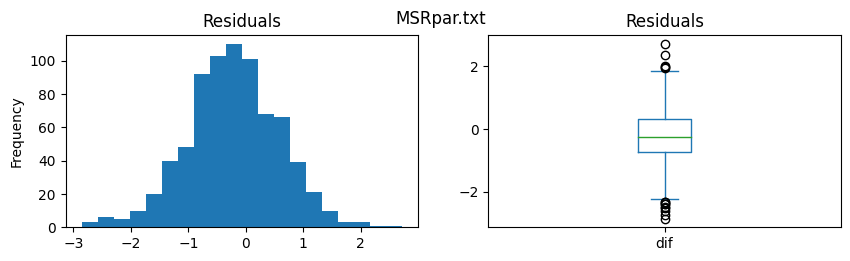

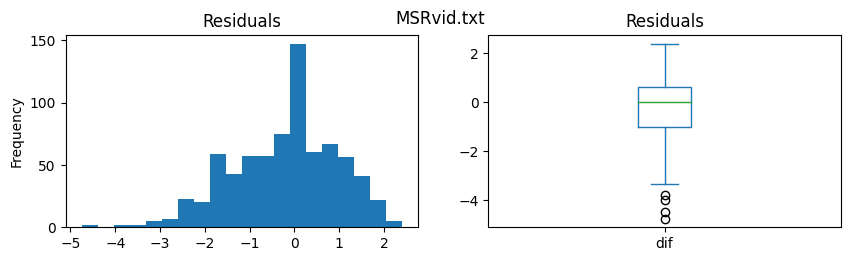

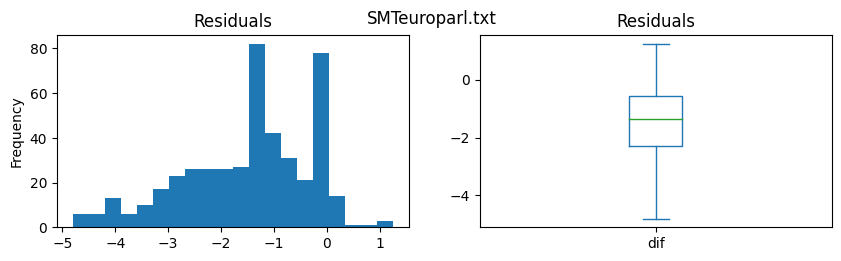

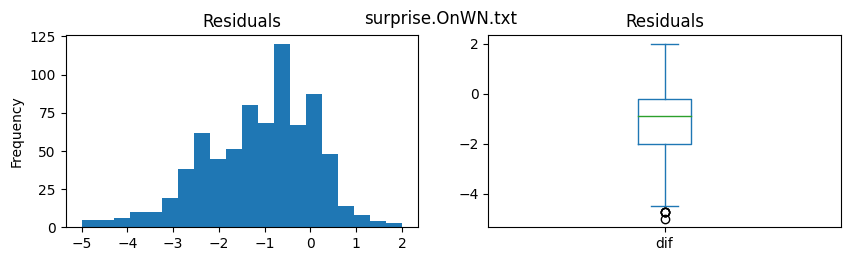

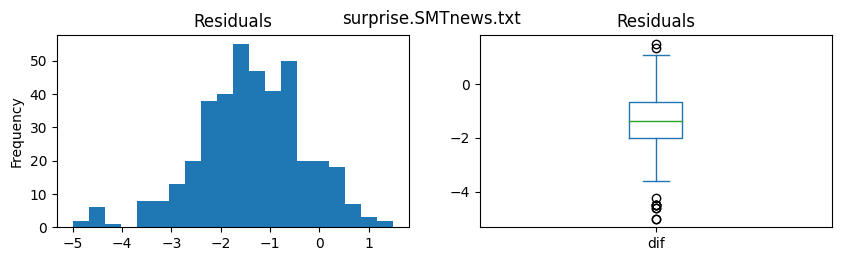

In [3]:

def spacy_preprocess_reviews(text, sw_lang='english', out_set=False):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''
    doc = nlp(text)
    ls_processed_text = [w.text.lower() for w in doc if not w.is_stop and not w.is_punct]

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]
baseline = STSAnalyzer(spacy_preprocess_reviews, 'surprise.OnWN.txt')
baseline.col_report(ls_files)
baseline.corr_table(ls_files, name='baseline')

In [4]:
print(f"Global Metric: {baseline.total_corr.statistic:.6f}")
baseline.df_scores

Global Metric: 0.592957


,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.561517,1.552373e-63,0.510448,0.608640,baseline
1,MSRvid.txt,0.711438,1.043983e-116,0.674186,0.745079,baseline
2,SMTeuroparl.txt,0.500409,1.849060e-30,0.428508,0.566012,baseline
3,surprise.OnWN.txt,0.651994,5.473821e-92,0.608823,0.691316,baseline
4,surprise.SMTnews.txt,0.454019,1.099026e-21,0.372445,0.528631,baseline


# Lemmatization and POS tagging

As seen in the baseline, using the whole word can result in the mismatch of the word form. In this section, we will use the lemmatized form of the word instead of the word itself. We will also use the POS tag of the word to further improve the performance.

Example from the baseline:

DIFFERENCE {'claims', 'date', 'var', 'xserve', 'xserves', 'single', 'retailer', 'claimed'}

"claims" and "claimed" correspond to the same concept but they haven't been identified as it because of the mismatch of the verb tense. Using the lemmatized form of the word, we can solve this problem.

MSRpar.txt


RAW TEXT (DIFFERENCE -2.40)
As part of his deal, Mr. Delainey has agreed to cooperate in the continuing investigation. 
 Dave Delainey agreed to cooperate with federal prosecutors in exchange for the plea.

PREPROCESSED TEXT
{'deal', 'continue', 'delainey', 'investigation', 'mr.', 'cooperate', 'agree'} 
 {'prosecutor', 'delainey', 'exchange', 'cooperate', 'dave', 'agree', 'federal', 'plea'}
INTERSECTION {'agree', 'cooperate', 'delainey'}
DIFFERENCE {'deal', 'prosecutor', 'exchange', 'investigation', 'mr.', 'dave', 'continue', 'federal', 'plea'}



RAW TEXT (DIFFERENCE -2.40)
He projected Vanderpool will be available within the next five years. 
 Products featuring Vanderpool will be released within five years, he said.

PREPROCESSED TEXT
{'vanderpool', 'available', 'project', 'year'} 
 {'year', 'feature', 'say', 'release', 'vanderpool', 'product'}
INTERSECTION {'vanderpool', 'year'}
DIFFERENCE {'project', 'release', 'feature', 'available', 'say', 'product'}



RAW TEXT (DI

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.568696,1.775337e-65,0.518205,0.615237,lemmatization
1,MSRvid.txt,0.789426,1.084696e-160,0.760835,0.814958,lemmatization
2,SMTeuroparl.txt,0.540785,3.207585e-36,0.472653,0.602491,lemmatization
3,surprise.OnWN.txt,0.655915,1.907613e-93,0.613116,0.694875,lemmatization
4,surprise.SMTnews.txt,0.429461,2.449293e-19,0.345869,0.506289,lemmatization


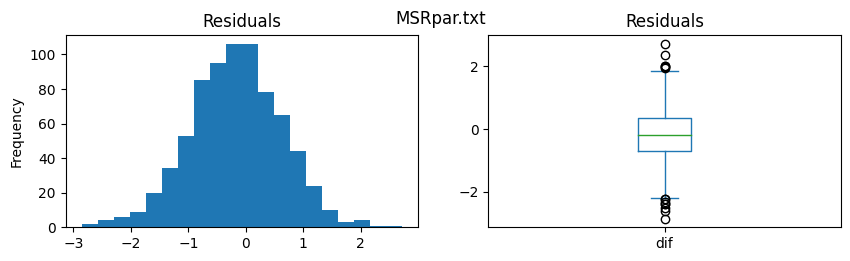

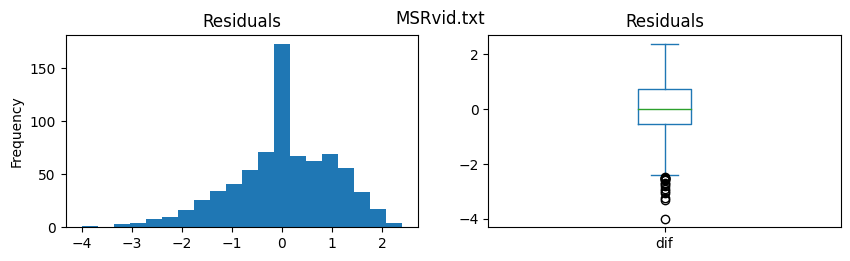

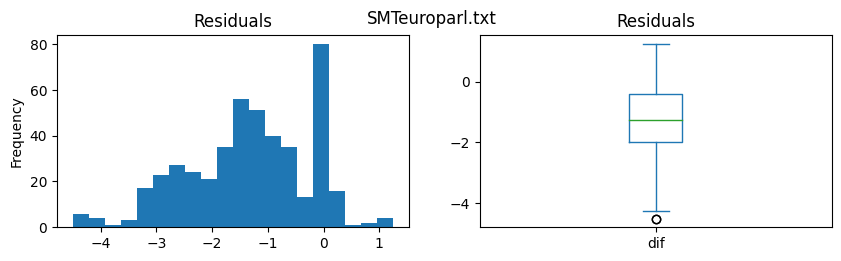

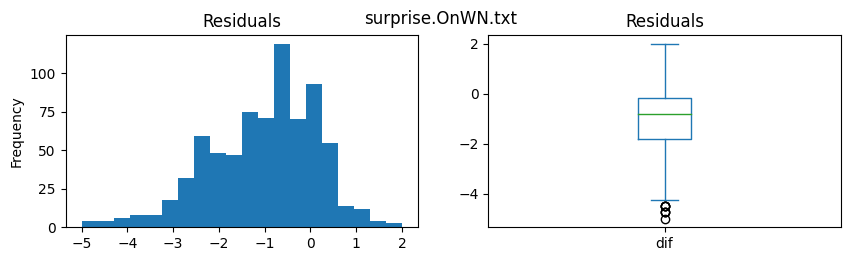

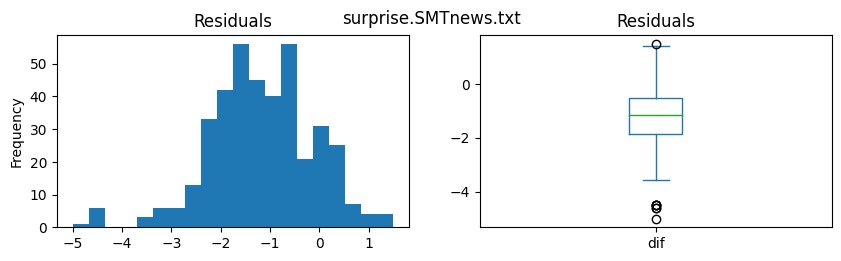

In [5]:
def spacy_preprocess_lemma(text, sw_lang='english', out_set=False):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''
    doc = nlp(text)
    ls_processed_text = [w.lemma_.lower() for w in doc if not w.is_stop and not w.is_punct]

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
lemmatized = STSAnalyzer(spacy_preprocess_lemma, 'surprise.OnWN.txt')
lemmatized.col_report(ls_files)
lemmatized.corr_table(ls_files, name='lemmatization')

In [6]:
print(f"Global Metric: {lemmatized.total_corr.statistic:.6f}")
lemmatized.df_scores

Global Metric: 0.627484


,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.568696,1.775337e-65,0.518205,0.615237,lemmatization
1,MSRvid.txt,0.789426,1.084696e-160,0.760835,0.814958,lemmatization
2,SMTeuroparl.txt,0.540785,3.207585e-36,0.472653,0.602491,lemmatization
3,surprise.OnWN.txt,0.655915,1.907613e-93,0.613116,0.694875,lemmatization
4,surprise.SMTnews.txt,0.429461,2.449293e-19,0.345869,0.506289,lemmatization


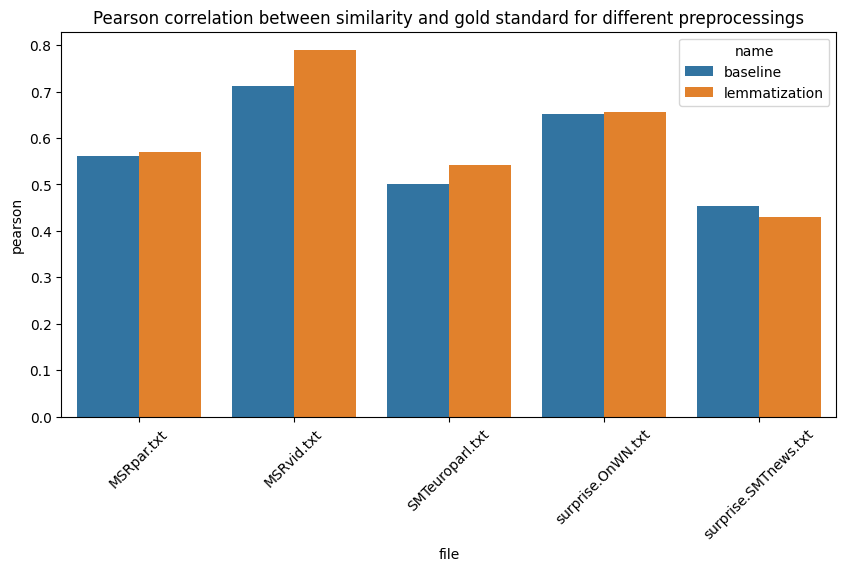

In [7]:
df_scores_comp = pd.concat([baseline.df_scores, lemmatized.df_scores], 
                            axis=0, ignore_index=True)
plt.figure(figsize=(10,5))
sns.barplot(x='file', y='pearson', hue='name', data=df_scores_comp)
plt.title('Pearson correlation between similarity and gold standard for different preprocessings')
plt.xticks(rotation=45);

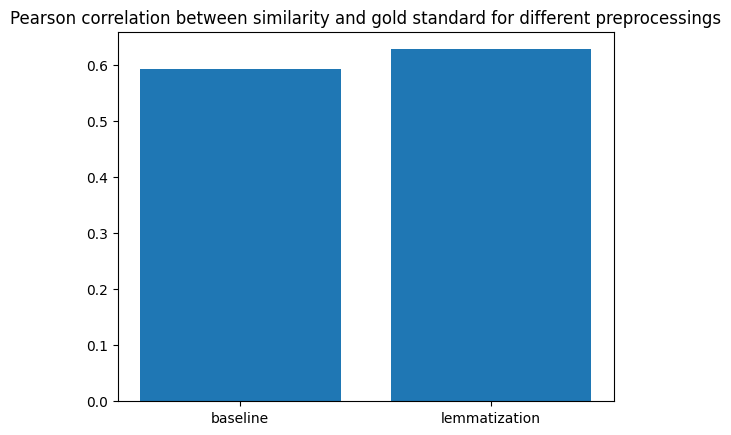

In [8]:
plt.bar(['baseline', 'lemmatization'], [baseline.total_corr.statistic, lemmatized.total_corr.statistic])
plt.title('Pearson correlation between similarity and gold standard for different preprocessings');

# Stemming

There are still some differencies between the words that have the same meaning

DIFFERENCE {'need', 'necessary'}
DIFFERENCE {'inflate', 'inflated', 'physically'}

or some like "potato" and "potatoe" that are just misspelled. We can use other word standardization techniques to solve this problem.

A good way of partially solving this can be chopping the words' termination using specific stemming rules. For example, we can use the Porter Stemmer algorithm to chop the words' termination.

## Porter Stemmer

MSRpar.txt


RAW TEXT (DIFFERENCE -2.40)
He projected Vanderpool will be available within the next five years. 
 Products featuring Vanderpool will be released within five years, he said.

PREPROCESSED TEXT
{'vanderpool', 'avail', 'project', 'year'} 
 {'featur', 'year', 'say', 'vanderpool', 'product', 'releas'}
INTERSECTION {'vanderpool', 'year'}
DIFFERENCE {'project', 'featur', 'product', 'avail', 'say', 'releas'}



RAW TEXT (DIFFERENCE -2.40)
As part of his deal, Mr. Delainey has agreed to cooperate in the continuing investigation. 
 Dave Delainey agreed to cooperate with federal prosecutors in exchange for the plea.

PREPROCESSED TEXT
{'deal', 'delainey', 'mr.', 'cooper', 'continu', 'agre', 'investig'} 
 {'exchang', 'prosecutor', 'delainey', 'cooper', 'dave', 'feder', 'agre', 'plea'}
INTERSECTION {'agre', 'cooper', 'delainey'}
DIFFERENCE {'deal', 'exchang', 'prosecutor', 'mr.', 'dave', 'feder', 'continu', 'investig', 'plea'}



RAW TEXT (DIFFERENCE -2.53)
But Odette is the first to

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.582289,2.747763e-69,0.532915,0.627712,Lemma+Porter
1,MSRvid.txt,0.803314,1.591675e-170,0.776373,0.827324,Lemma+Porter
2,SMTeuroparl.txt,0.524704,7.826421e-34,0.455030,0.587993,Lemma+Porter
3,surprise.OnWN.txt,0.681337,1.868993e-103,0.641015,0.717909,Lemma+Porter
4,surprise.SMTnews.txt,0.436103,5.924332e-20,0.353044,0.512342,Lemma+Porter


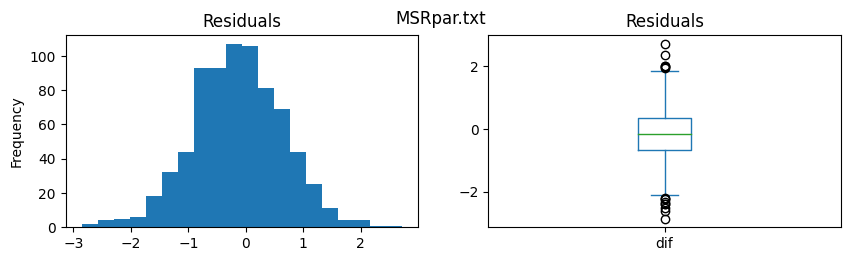

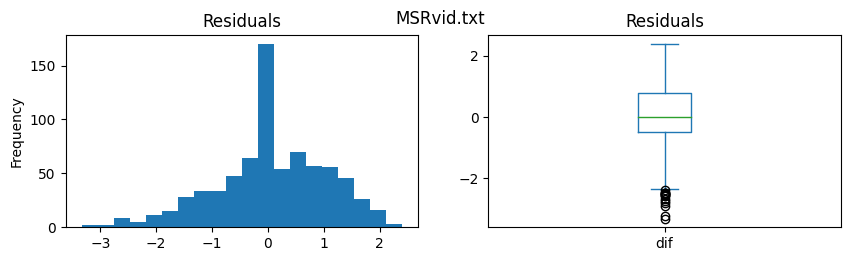

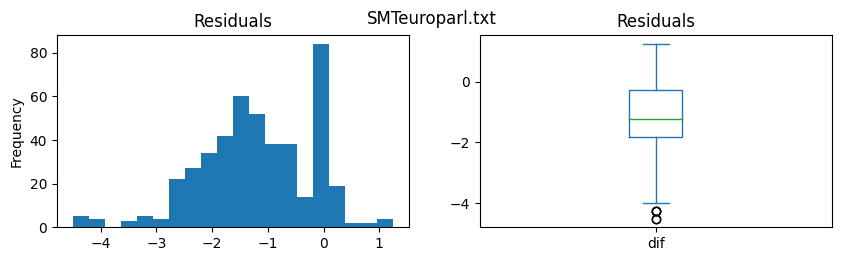

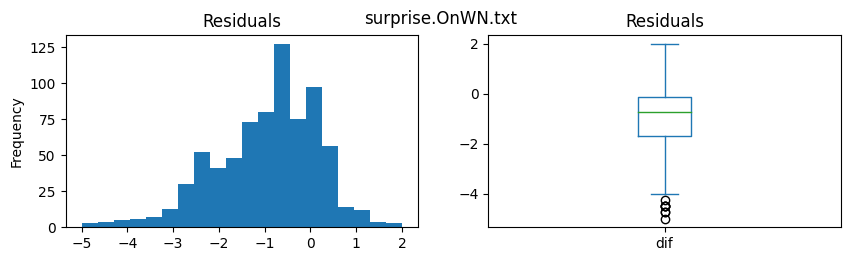

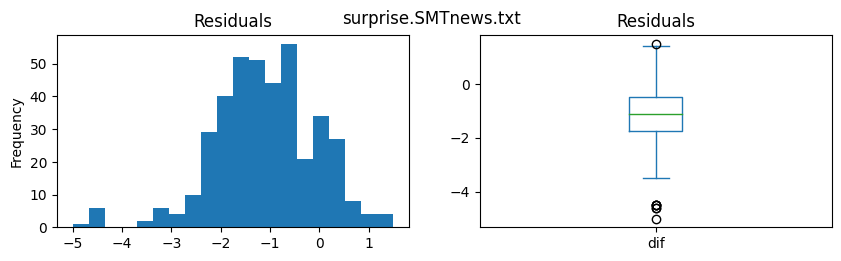

In [9]:

def spacy_preprocess_lemma_porter(text, sw_lang='english', out_set=False):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''
    doc = nlp(text)
    stemmer = PorterStemmer()
    ls_processed_text = [stemmer.stem(w.lemma_.lower()) for w in doc if not w.is_stop and not w.is_punct]

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]
lemma_porter = STSAnalyzer(spacy_preprocess_lemma_porter, 'surprise.OnWN.txt')
lemma_porter.col_report(ls_files)
lemma_porter.corr_table(ls_files, name='Lemma+Porter')

In [10]:
print(f"Global Metric: {lemma_porter.total_corr.statistic:.6f}")
lemma_porter.df_scores

Global Metric: 0.655437


,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.582289,2.747763e-69,0.532915,0.627712,Lemma+Porter
1,MSRvid.txt,0.803314,1.591675e-170,0.776373,0.827324,Lemma+Porter
2,SMTeuroparl.txt,0.524704,7.826421e-34,0.455030,0.587993,Lemma+Porter
3,surprise.OnWN.txt,0.681337,1.868993e-103,0.641015,0.717909,Lemma+Porter
4,surprise.SMTnews.txt,0.436103,5.924332e-20,0.353044,0.512342,Lemma+Porter


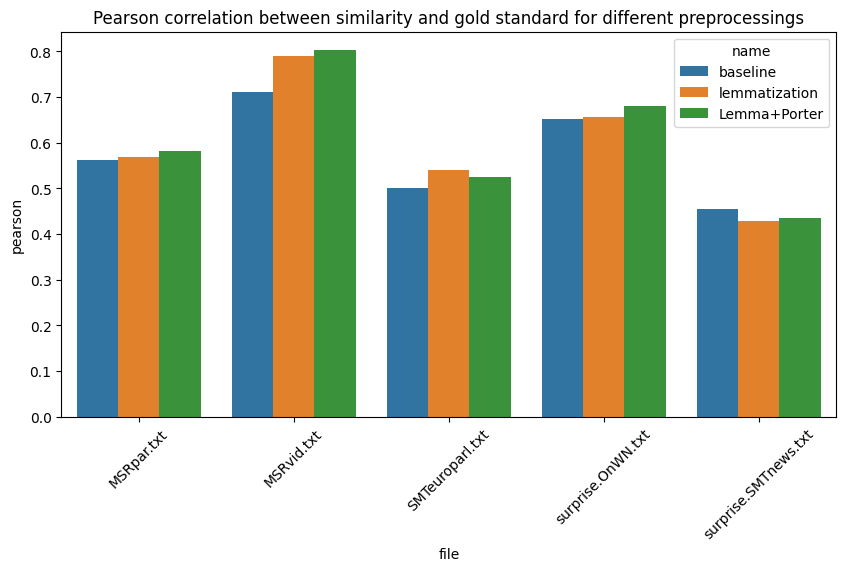

In [11]:
df_scores_comp = pd.concat([baseline.df_scores, lemmatized.df_scores, lemma_porter.df_scores], 
                            axis=0, ignore_index=True)
plt.figure(figsize=(10,5))
sns.barplot(x='file', y='pearson', hue='name', data=df_scores_comp)
plt.title('Pearson correlation between similarity and gold standard for different preprocessings')
plt.xticks(rotation=45);

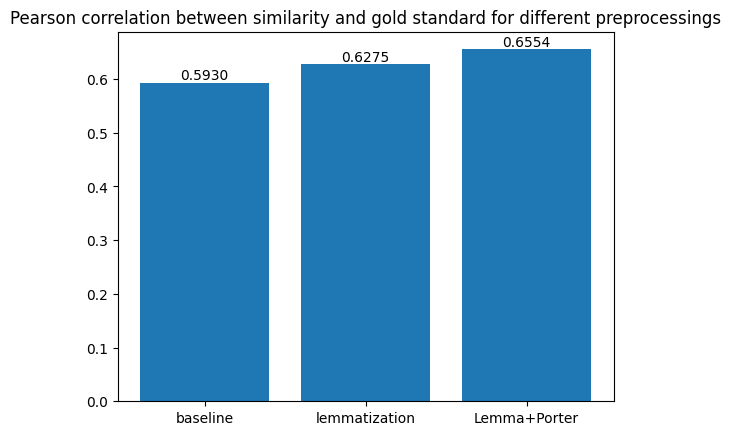

In [12]:
ls_corr_results = [baseline.total_corr.statistic, 
                   lemmatized.total_corr.statistic,
                   lemma_porter.total_corr.statistic]

ls_names = ['baseline', 'lemmatization', 'Lemma+Porter']

plt.bar(ls_names, ls_corr_results)
for i in range(len(ls_names)):
    plt.text(i, ls_corr_results[i], f"{ls_corr_results[i]:.4f}", ha='center', va='bottom')
plt.title('Pearson correlation between similarity and gold standard for different preprocessings');

## Snowball Stemmer

MSRpar.txt


RAW TEXT (DIFFERENCE -2.40)
He projected Vanderpool will be available within the next five years. 
 Products featuring Vanderpool will be released within five years, he said.

PREPROCESSED TEXT
{'vanderpool', 'avail', 'project', 'year'} 
 {'featur', 'year', 'say', 'vanderpool', 'product', 'releas'}
INTERSECTION {'vanderpool', 'year'}
DIFFERENCE {'project', 'featur', 'product', 'avail', 'say', 'releas'}



RAW TEXT (DIFFERENCE -2.40)
As part of his deal, Mr. Delainey has agreed to cooperate in the continuing investigation. 
 Dave Delainey agreed to cooperate with federal prosecutors in exchange for the plea.

PREPROCESSED TEXT
{'deal', 'delainey', 'mr.', 'cooper', 'continu', 'agre', 'investig'} 
 {'exchang', 'prosecutor', 'delainey', 'cooper', 'dave', 'feder', 'agre', 'plea'}
INTERSECTION {'agre', 'cooper', 'delainey'}
DIFFERENCE {'deal', 'exchang', 'prosecutor', 'mr.', 'dave', 'feder', 'continu', 'investig', 'plea'}



RAW TEXT (DIFFERENCE -2.53)
But Odette is the first to

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.579991,1.247272e-68,0.530426,0.625604,Lemma+Snowball
1,MSRvid.txt,0.802010,1.439070e-169,0.774913,0.826165,Lemma+Snowball
2,SMTeuroparl.txt,0.524704,7.826421e-34,0.455030,0.587993,Lemma+Snowball
3,surprise.OnWN.txt,0.680257,5.219165e-103,0.639827,0.716932,Lemma+Snowball
4,surprise.SMTnews.txt,0.432086,1.403083e-19,0.348703,0.508682,Lemma+Snowball


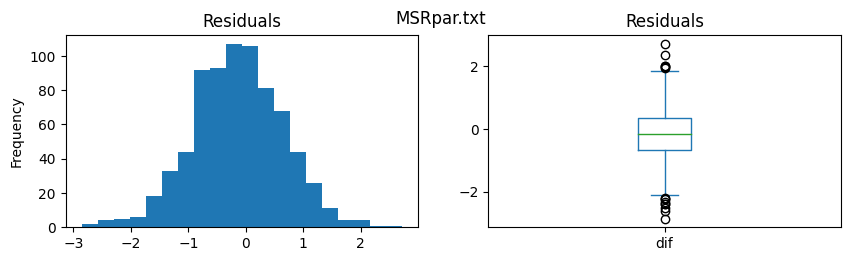

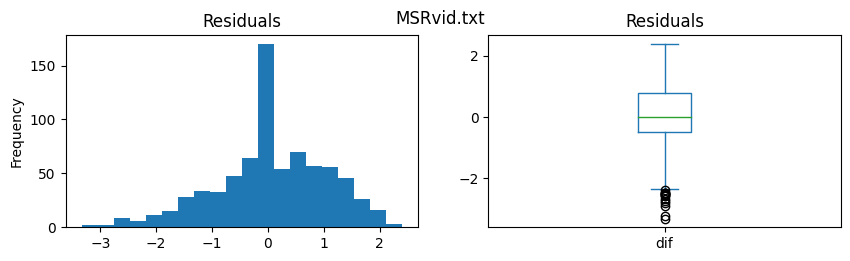

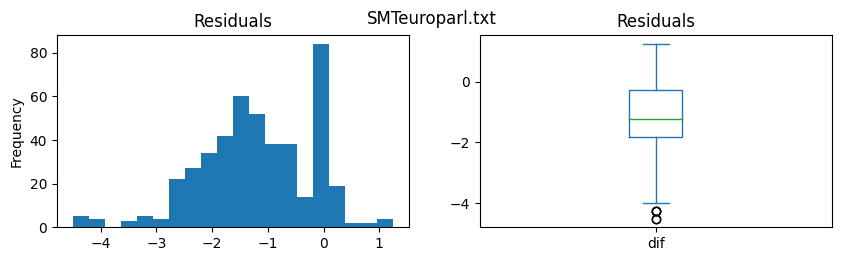

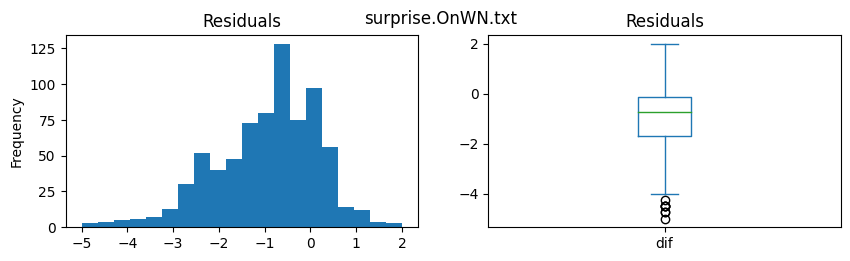

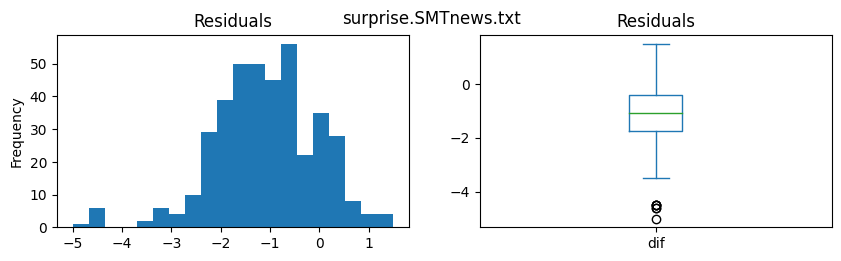

In [13]:

def spacy_preprocess_lemma_snowball(text, sw_lang='english', out_set=False):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''
    doc = nlp(text)
    stemmer = SnowballStemmer(sw_lang)
    ls_processed_text = [stemmer.stem(w.lemma_.lower()) for w in doc if not w.is_stop and not w.is_punct]

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]
lemma_snow = STSAnalyzer(spacy_preprocess_lemma_snowball, 'surprise.OnWN.txt')
lemma_snow.col_report(ls_files)
lemma_snow.corr_table(ls_files, name='Lemma+Snowball')

In [14]:
print(f"Global Metric: {lemma_snow.total_corr.statistic:.6f}")
lemma_snow.df_scores

Global Metric: 0.655390


,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.579991,1.247272e-68,0.530426,0.625604,Lemma+Snowball
1,MSRvid.txt,0.802010,1.439070e-169,0.774913,0.826165,Lemma+Snowball
2,SMTeuroparl.txt,0.524704,7.826421e-34,0.455030,0.587993,Lemma+Snowball
3,surprise.OnWN.txt,0.680257,5.219165e-103,0.639827,0.716932,Lemma+Snowball
4,surprise.SMTnews.txt,0.432086,1.403083e-19,0.348703,0.508682,Lemma+Snowball


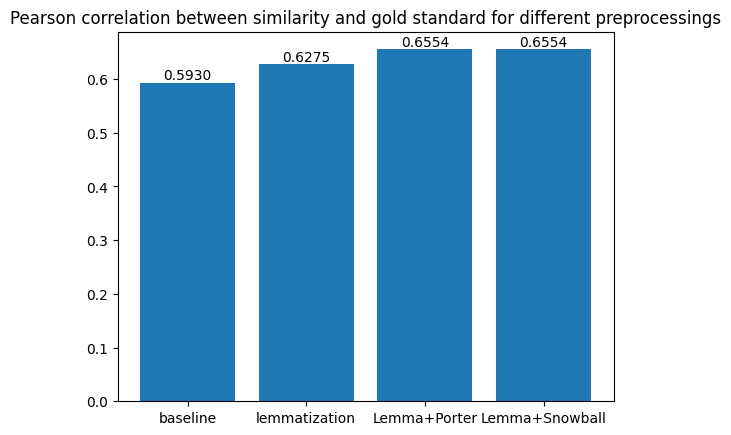

In [15]:
ls_corr_results = [baseline.total_corr.statistic, 
                   lemmatized.total_corr.statistic,
                   lemma_porter.total_corr.statistic,
                   lemma_snow.total_corr.statistic]

ls_names = ['baseline', 'lemmatization', 'Lemma+Porter', 'Lemma+Snowball']

plt.bar(ls_names, ls_corr_results)
for i in range(len(ls_names)):
    plt.text(i, ls_corr_results[i], f"{ls_corr_results[i]:.4f}", ha='center', va='bottom')
plt.title('Pearson correlation between similarity and gold standard for different preprocessings');

# Semantic Approach

In [16]:
d_pos = {'NOUN':'n', 'VERB':'v', 'ADJ':'a', 'ADV':'r'}

In [17]:


sentence_sim_terms("I have needs", "I have necessities")


('needs', 'needs')

In [18]:
hora = "Todo ocurrio a las 1h30am"
import re
re.sub(r'\d+[hH]*[^\w]*\d*[^\w]*[pPaA]\.{0,1}[mM]\.{0,1}', '[HORA]', hora)

'Todo ocurrio a las [HORA]'

In [19]:
cifra  = "el prcio total es de 2,300.2 3"
import re
re.sub(r'(\d+[\,\.]*)+', '[HORA]', cifra)

'el prcio total es de [HORA] [HORA]'

In [20]:
re.sub(r'\d+[^\w]*[hH]*[^\w]*\d*[^\w]*([pPaA]\.{0,1})*([mM]\.{0,1})*', '[HTAG]', "17 : 30 p.m")

'[HTAG]'

MSRpar.txt


RAW TEXT (DIFFERENCE -2.14)
Appellate courts across the country have issued differing rulings on the issue, allowing public displays of the Ten Commandments in some cases and banning them in others. 
 Lower courts have splintered on the issue, allowing depictions of the Ten Commandments in some instances and not in others.

PREPROCESSED TEXT
{'public', 'display', 'command', 'appel', 'ban', 'rule', 'allow', 'countri', 'differ', 'issu', 'court', 'case'} 
 {'low', 'splinter', 'command', 'allow', 'depict', 'issu', 'court', 'instanc'}
INTERSECTION {'issu', 'command', 'allow', 'court'}
DIFFERENCE {'public', 'low', 'display', 'splinter', 'appel', 'ban', 'rule', 'countri', 'differ', 'depict', 'case', 'instanc'}



SEMANTICAL MODIFICATION

RAW TEXT (DIFFERENCE -2.14)
appellate courts country issued differing rulings issue allowing public displays commandments cases banning 
 cases cases lower courts splintered allowing depictions commandments

PREPROCESSED TEXT
{'public', 'display'

,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.610592,7.980184e-78,0.563641,0.653611,Lemma+Porter+SenSim
1,MSRvid.txt,0.802200,1.044455e-169,0.775126,0.826334,Lemma+Porter+SenSim
2,SMTeuroparl.txt,0.461484,1.375542e-25,0.386273,0.530599,Lemma+Porter+SenSim
3,surprise.OnWN.txt,0.684392,9.999479e-105,0.644374,0.720672,Lemma+Porter+SenSim
4,surprise.SMTnews.txt,0.523912,1.654357e-29,0.448823,0.591655,Lemma+Porter+SenSim


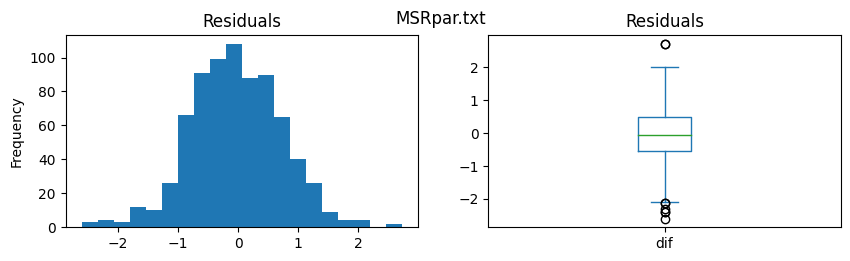

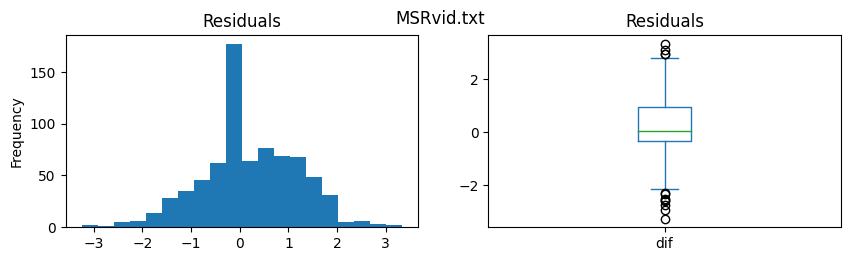

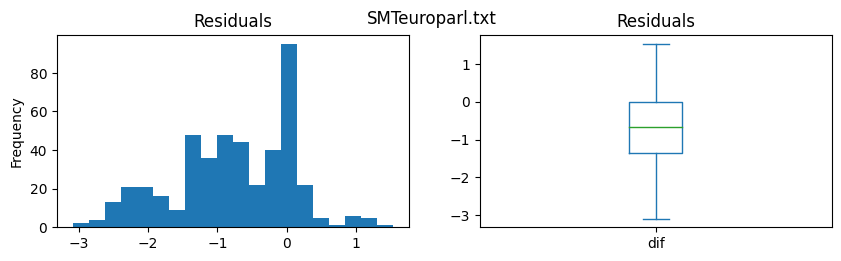

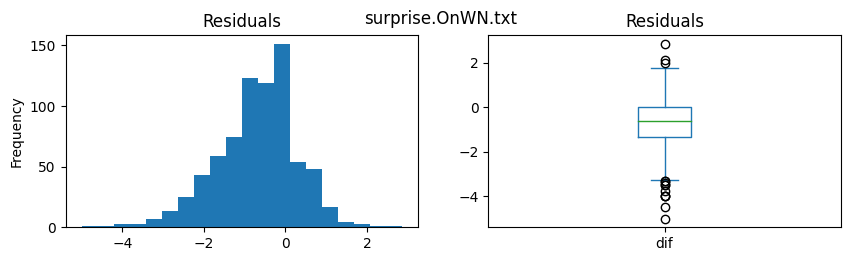

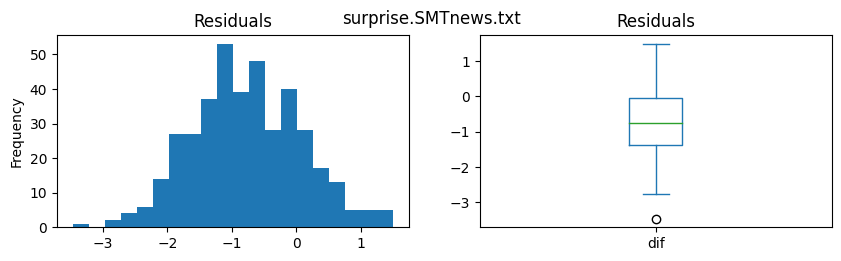

In [21]:

def spacy_preprocess_lemma_porter(text, sw_lang='english', out_set=False):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''

    # import re
    # text = re.sub(r'\d+[hH]*[^\w]*\d*[^\w]*[pPaA]\.{0,1}[mM]\.{0,1}', '[HTAG]', text)
    doc = nlp(text)
    stemmer = PorterStemmer()
    ls_processed_text = [stemmer.stem(w.lemma_.lower()) for w in doc if not w.is_stop and not w.is_punct]

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]
lemma_porter_sen_sim = STSAnalyzer(spacy_preprocess_lemma_porter, 'surprise.OnWN.txt', semantic_fun=sentence_sim_terms)
lemma_porter_sen_sim.col_report(ls_files)
lemma_porter_sen_sim.corr_table(ls_files, name='Lemma+Porter+SenSim')

In [22]:
print(f"Global Metric: {lemma_porter_sen_sim.total_corr.statistic:.6f}")
lemma_porter_sen_sim.df_scores

Global Metric: 0.710853


,file,pearson,p_value,conf_low,conf_high,name
0,MSRpar.txt,0.610592,7.980184e-78,0.563641,0.653611,Lemma+Porter+SenSim
1,MSRvid.txt,0.802200,1.044455e-169,0.775126,0.826334,Lemma+Porter+SenSim
2,SMTeuroparl.txt,0.461484,1.375542e-25,0.386273,0.530599,Lemma+Porter+SenSim
3,surprise.OnWN.txt,0.684392,9.999479e-105,0.644374,0.720672,Lemma+Porter+SenSim
4,surprise.SMTnews.txt,0.523912,1.654357e-29,0.448823,0.591655,Lemma+Porter+SenSim


In [306]:
df_euro = lemma_porter_sen_sim.df_col_analysis
df_euro = df_euro[df_euro.file == 'MSRpar.txt']
df_euro = df_euro.sort_values(by='dif', ascending=True)
for idx, row in df_euro.iterrows():
    x, y = row[0], row[1]
    sem_x, sem_y = sentence_sim_terms(x, y)
    prep_x, prep_y = lemma_porter_sen_sim.preprocess_fun(sem_x, out_set=True), lemma_porter_sen_sim.preprocess_fun(sem_y, out_set=True)
    print(f"RAW TEXT (DIFFERENCE {row['dif']:.2f}) ** {row['sim']:.2f} vs {row['gs']:.2f}")
    print(x, '\n', y)
    print("\nPREPROCESSED TEXT")
    print(prep_x, '\n', prep_y)
    print("INTERSECTION", prep_x.intersection(prep_y))
    print("DIFFERENCE", prep_x.difference(prep_y).union(prep_y.difference(prep_x)))
    print('\n\n')

RAW TEXT (DIFFERENCE -2.61) ** 2.14 vs 4.75
The computers were reportedly located in the U.S., Canada and South Korea. 
 The PCs are scattered across the United States, Canada and South Korea.

PREPROCESSED TEXT
{'comput', 'locat', 'korea', 'canada', 'south', 'u.', 'reportedli'} 
 {'scatter', 'unit', 'korea', 'pc', 'state', 'south', 'canada'}
INTERSECTION {'korea', 'canada', 'south'}
DIFFERENCE {'comput', 'scatter', 'locat', 'unit', 'pc', 'state', 'u.', 'reportedli'}



RAW TEXT (DIFFERENCE -2.40) ** 2.00 vs 4.40
As part of his deal, Mr. Delainey has agreed to cooperate in the continuing investigation. 
 Dave Delainey agreed to cooperate with federal prosecutors in exchange for the plea.

PREPROCESSED TEXT
{'agre', 'deal', 'investig', 'delainey', 'continu', 'cooper', 'mr'} 
 {'plea', 'feder', 'agre', 'exchang', 'delainey', 'prosecutor', 'dave', 'cooper'}
INTERSECTION {'agre', 'cooper', 'delainey'}
DIFFERENCE {'plea', 'feder', 'deal', 'investig', 'exchang', 'prosecutor', 'dave', 'contin

In [360]:
df_scores_comp = pd.concat([baseline.df_scores, lemmatized.df_scores, lemma_porter.df_scores, lemma_porter_sen_sim.df_scores], 
                            axis=0, ignore_index=True)
plt.figure(figsize=(10,5))
sns.barplot(x='file', y='pearson', hue='name', data=df_scores_comp)
plt.title('Pearson correlation between similarity and gold standard for different preprocessings')
plt.xticks(rotation=45);

AttributeError: 'STSAnalyzer' object has no attribute 'df_scores'